In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear, Dropout
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.utils import add_self_loops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00


In [ ]:
data = pd.read_csv('Untitled.csv')
data = data.T
data.columns = data.iloc[0]
data = data[1:]
data = data.iloc[1:]
data.fillna(data.mean(), inplace=True)

In [ ]:
dataAD = data[data['Diagnosis'] != 0]
dataAD['Diagnosis'] = dataAD['Diagnosis'] - 1
data1_y = pd.to_numeric(dataAD['Diagnosis'], errors='coerce').astype('Int64')
data1_X = dataAD.drop('Diagnosis', axis=1)
data1_X = data1_X.iloc[:, :-1]
train_xs, test_xs, train_y, test_y = train_test_split(
    data1_X,
    data1_y,
    test_size=0.2,
    random_state=42,
    stratify=data1_y
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_xs = train_xs.to_numpy() if hasattr(train_xs, 'to_numpy') else np.array(train_xs)
train_y = train_y.to_numpy() if hasattr(train_y, 'to_numpy') else np.array(train_y)
test_xs = test_xs.to_numpy() if hasattr(test_xs, 'to_numpy') else np.array(test_xs)
test_y = test_y.to_numpy() if hasattr(test_y, 'to_numpy') else np.array(test_y)

pca = PCA(n_components=250)
reduced_train_xs = pca.fit_transform(train_xs)
reduced_test_xs = pca.transform(test_xs)
combined_xs = np.concatenate([reduced_train_xs, reduced_test_xs], axis=0)
combined_y = np.concatenate([train_y, test_y], axis=0)
num_train = train_xs.shape[0]
train_mask = torch.zeros(combined_xs.shape[0], dtype=torch.bool)
test_mask = torch.zeros(combined_xs.shape[0], dtype=torch.bool)
train_mask[:num_train] = True
test_mask[num_train:] = True

x = torch.tensor(combined_xs, dtype=torch.float)
y = torch.tensor(combined_y, dtype=torch.long)

k = 5
knn_adj_matrix = kneighbors_graph(combined_xs, n_neighbors=k, mode='connectivity').toarray()
edge_index = np.array(np.nonzero(knn_adj_matrix))
edge_index = torch.tensor(edge_index, dtype=torch.long)

edge_index, _ = add_self_loops(edge_index)
data = Data(x=x, y=y, edge_index=edge_index, train_mask=train_mask, test_mask=test_mask).to(device)

print(f"Node features shape: {data.x.shape}")
print(f"Labels shape: {data.y.shape}")
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Training nodes: {data.train_mask.sum().item()}, Testing nodes: {data.test_mask.sum().item()}")

Node features shape: torch.Size([314, 250])
Labels shape: torch.Size([314])
Edge index shape: torch.Size([2, 1884])
Training nodes: 251, Testing nodes: 63


Epoch 10, Loss: 0.1341, Test Accuracy: 0.9206
Epoch 20, Loss: 0.0283, Test Accuracy: 0.9365
Epoch 30, Loss: 0.0145, Test Accuracy: 0.9683
Epoch 40, Loss: 0.0001, Test Accuracy: 0.9365
Epoch 50, Loss: 0.0001, Test Accuracy: 0.9683
Epoch 60, Loss: 0.0002, Test Accuracy: 0.9683
Epoch 70, Loss: 0.0142, Test Accuracy: 0.9683
Epoch 80, Loss: 0.0007, Test Accuracy: 0.9365
Epoch 90, Loss: 0.0000, Test Accuracy: 0.9524
Epoch 100, Loss: 0.0004, Test Accuracy: 0.9683
Confusion Matrix:
[[30  2]
 [ 0 31]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        32
           1       0.94      1.00      0.97        31

    accuracy                           0.97        63
   macro avg       0.97      0.97      0.97        63
weighted avg       0.97      0.97      0.97        63



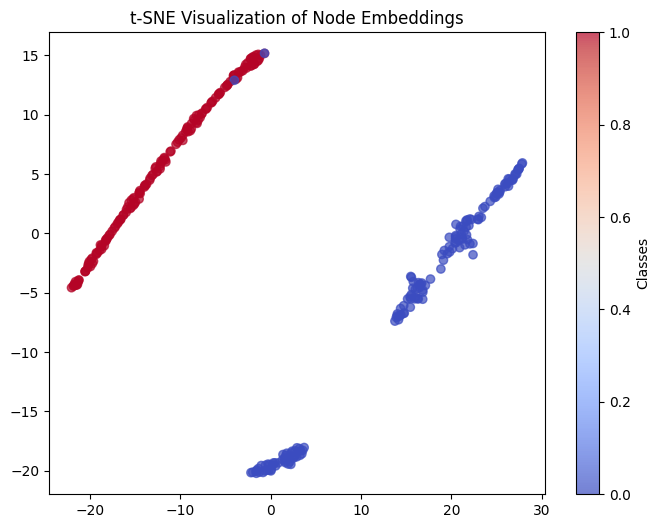

In [ ]:
class GraphSAGEModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(GraphSAGEModel, self).__init__()
        self.fc1 = Linear(input_dim, hidden_dim)
        self.sage1 = SAGEConv(hidden_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, hidden_dim)
        self.dropout = Dropout(dropout_rate)
        self.fc2 = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.sage1(x, edge_index)))
        x = self.dropout(F.relu(self.sage2(x, edge_index)))
        x = self.fc2(x)
        return x

data.edge_index, _ = add_self_loops(data.edge_index)

k = 5
knn_adj_matrix = kneighbors_graph(data.x.cpu().numpy(), n_neighbors=k, mode='connectivity').toarray()
edge_index = np.array(np.nonzero(knn_adj_matrix))
data.edge_index = torch.tensor(edge_index, dtype=torch.long).to(device)

criterion = F.cross_entropy

input_dim = data.x.size(1)
hidden_dim = 256
output_dim = len(torch.unique(data.y))
dropout_rate = 0.5

model = GraphSAGEModel(input_dim, hidden_dim, output_dim, dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        model.eval()
        _, pred = out.max(dim=1)
        acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Test Accuracy: {acc:.4f}")

model.eval()
_, pred = model(data).max(dim=1)

true_labels = data.y[data.test_mask].cpu().numpy()
predictions = pred[data.test_mask].cpu().numpy()

print("Confusion Matrix:")
print(confusion_matrix(true_labels, predictions))
print("\nClassification Report:")
print(classification_report(true_labels, predictions))

embeddings = model(data).detach().cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=data.y.cpu().numpy(), cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Classes')
plt.title("t-SNE Visualization of Node Embeddings")
plt.show()


In [ ]:
torch.save(model.state_dict(), 'graphsage_model_weights.pth')


In [13]:
class GraphSAGEModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(GraphSAGEModel, self).__init__()
        self.fc1 = Linear(input_dim, hidden_dim)
        self.sage1 = SAGEConv(hidden_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, hidden_dim)
        self.dropout = Dropout(dropout_rate)
        self.fc2 = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.sage1(x, edge_index)))
        x = self.dropout(F.relu(self.sage2(x, edge_index)))
        x = self.fc2(x)
        return x

In [ ]:
input_dim = data.x.size(1)
hidden_dim = 256
output_dim = len(torch.unique(data.y))
dropout_rate = 0.5

model = GraphSAGEModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model.load_state_dict(torch.load("graphsage_model_weights.pth"))
model.eval()

<ipython-input-15-ecdc697c8e23>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("graphsage_model_weights.pth"))


GraphSAGEModel(
  (fc1): Linear(in_features=250, out_features=256, bias=True)
  (sage1): SAGEConv(256, 256, aggr=mean)
  (sage2): SAGEConv(256, 256, aggr=mean)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [16]:
_, pred = model(data).max(dim=1)
true_labels = data.y[data.test_mask].cpu().numpy()
predictions = pred[data.test_mask].cpu().numpy()
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predictions))
print("\nClassification Report:")
print(classification_report(true_labels, predictions))

Confusion Matrix:
[[30  2]
 [ 0 31]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        32
           1       0.94      1.00      0.97        31

    accuracy                           0.97        63
   macro avg       0.97      0.97      0.97        63
weighted avg       0.97      0.97      0.97        63



In [18]:
model.eval()
with torch.no_grad():
    logits = model(data)
    probabilities = F.softmax(logits, dim=1)
test_probs = probabilities[data.test_mask]
test_labels = data.y[data.test_mask]
test_probs_np = test_probs.cpu().numpy()
test_labels_np = test_labels.cpu().numpy()
true_labels = np.array([true_labels])

In [ ]:
if hasattr(test_probs, 'cpu'):
    test_probs_np = test_probs.cpu().numpy()
else:
    test_probs_np = test_probs
true_labels_np = test_y

mask = (true_labels_np == 0) | (true_labels_np == 1)
filtered_true = true_labels_np[mask]
filtered_pred = test_probs_np[mask]
binary_true = (filtered_true == 1).astype(int)
binary_pred = filtered_pred[:, 1]
auc_roc = roc_auc_score(binary_true, binary_pred)
print(f"AUC-ROC score between class 1 and 0: {auc_roc:.4f}")

AUC-ROC score between class 1 and 0: 0.9824
